# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wis     1206 non-null   int64 
 1   cha     1206 non-null   int64 
 2   int     1206 non-null   int64 
 3   con     1206 non-null   int64 
 4   hp      1206 non-null   int64 
 5   ac      1206 non-null   int64 
 6   dex     1206 non-null   int64 
 7   str     1206 non-null   int64 
 8   book    1206 non-null   object
 9   level   1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,wis,cha,int,con,hp,ac,dex,str,book,level
0,2,1,1,5,215,29,2,7,Pathfinder Bestiary,10
1,2,1,-4,5,220,28,0,9,Pathfinder Bestiary,10
2,3,-2,-4,6,175,25,3,7,Pathfinder Bestiary,8
3,5,6,6,5,315,41,4,7,Pathfinder Bestiary,17
4,1,1,-1,1,20,16,3,-5,Pathfinder Bestiary,1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


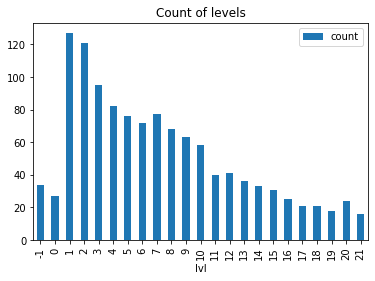

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 8
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.67
MAE: 0.47


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.67


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

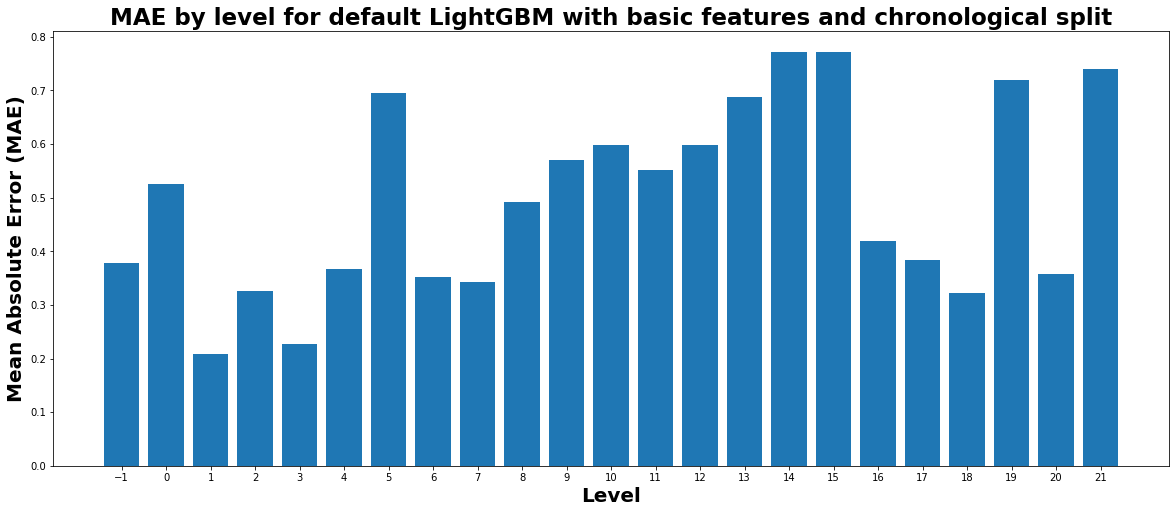

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.67

Round type: 0.5
RMSE: 0.71

Round type: 0.33
RMSE: 0.71

Round type: 0.45
RMSE: 0.70



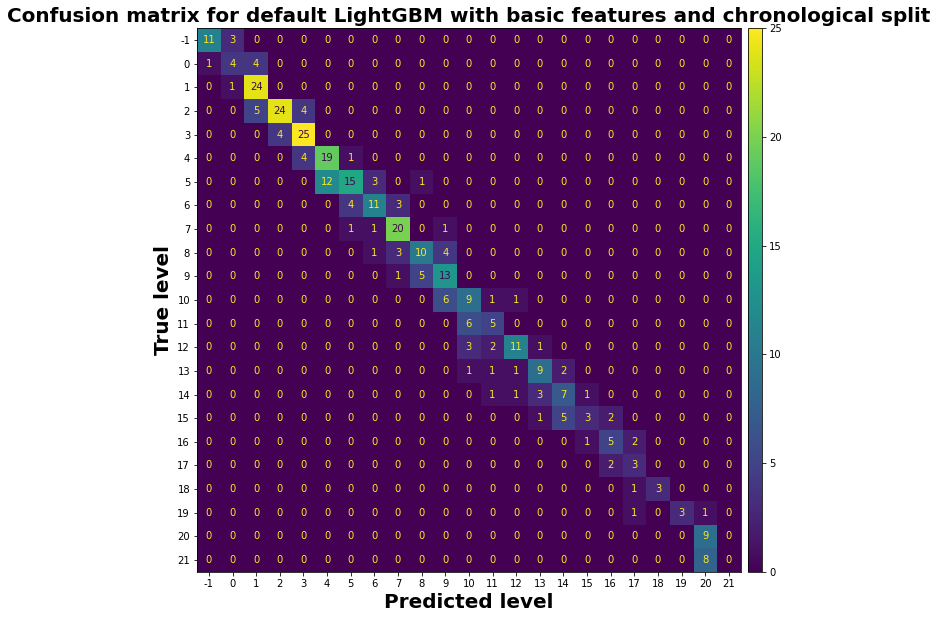

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 20:46:43,375] A new study created in memory with name: no-name-12ccd92e-dc2c-4eb2-ad33-974e2d85ec27
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742


feature_fraction, val_score: 0.220042:  14%|######4                                      | 1/7 [00:01<00:08,  1.40s/it]

[300]	cv_agg's l2: 0.220675 + 0.0454667
Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.229812 + 0.0493027
[200]	cv_agg's l2: 0.225609 + 0.0477596
[300]	cv_agg's l2: 0.226947 + 0.047554


feature_fraction, val_score: 0.220042:  29%|############8                                | 2/7 [00:03<00:07,  1.59s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.35167 + 0.0673381
[200]	cv_agg's l2: 0.298985 + 0.0568226
[300]	cv_agg's l2: 0.282636 + 0.051219


feature_fraction, val_score: 0.220042:  43%|###################2                         | 3/7 [00:06<00:10,  2.57s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.404458 + 0.0921388
[200]	cv_agg's l2: 0.342887 + 0.0774405
[300]	cv_agg's l2: 0.320127 + 0.0706401


feature_fraction, val_score: 0.220042:  57%|#########################7                   | 4/7 [00:11<00:10,  3.41s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.227136 + 0.0457577
[200]	cv_agg's l2: 0.222943 + 0.0444917
[300]	cv_agg's l2: 0.22502 + 0.0444347


feature_fraction, val_score: 0.220042:  71%|################################1            | 5/7 [00:16<00:08,  4.02s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.229812 + 0.0493027
[200]	cv_agg's l2: 0.225609 + 0.0477596
[300]	cv_agg's l2: 0.226947 + 0.047554


feature_fraction, val_score: 0.220042:  86%|######################################5      | 6/7 [00:20<00:04,  4.10s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.23413 + 0.0515182
[200]	cv_agg's l2: 0.232574 + 0.049644
[300]	cv_agg's l2: 0.234584 + 0.0510205


feature_fraction, val_score: 0.220042: 100%|#############################################| 7/7 [00:24<00:00,  3.56s/it]


Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659


num_leaves, val_score: 0.220042:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:   5%|##5                                               | 1/20 [00:03<01:12,  3.82s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  10%|#####                                             | 2/20 [00:07<01:09,  3.85s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  15%|#######5                                          | 3/20 [00:11<01:05,  3.88s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.232793 + 0.0435038
[200]	cv_agg's l2: 0.224466 + 0.0417841


num_leaves, val_score: 0.220042:  20%|##########                                        | 4/20 [00:13<00:52,  3.27s/it]

[300]	cv_agg's l2: 0.221236 + 0.0403019
Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  25%|############5                                     | 5/20 [00:17<00:52,  3.48s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  30%|###############                                   | 6/20 [00:21<00:49,  3.51s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  35%|#################5                                | 7/20 [00:25<00:47,  3.68s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  40%|####################                              | 8/20 [00:29<00:44,  3.70s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  45%|######################5                           | 9/20 [00:32<00:40,  3.72s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  50%|########################5                        | 10/20 [00:36<00:37,  3.72s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  55%|##########################9                      | 11/20 [00:40<00:33,  3.72s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  60%|#############################4                   | 12/20 [00:44<00:29,  3.73s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  65%|###############################8                 | 13/20 [00:48<00:26,  3.80s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  70%|##################################3              | 14/20 [00:51<00:23,  3.84s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  75%|####################################7            | 15/20 [00:56<00:19,  3.91s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  80%|#######################################2         | 16/20 [01:01<00:17,  4.34s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  85%|#########################################6       | 17/20 [01:05<00:12,  4.20s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  90%|############################################1    | 18/20 [01:09<00:08,  4.14s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042:  95%|##############################################5  | 19/20 [01:13<00:04,  4.06s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


num_leaves, val_score: 0.220042: 100%|#################################################| 20/20 [01:17<00:00,  3.86s/it]


Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659


bagging, val_score: 0.220042:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.246952 + 0.0538385
[200]	cv_agg's l2: 0.238038 + 0.0592441
[300]	cv_agg's l2: 0.234962 + 0.056993


bagging, val_score: 0.220042:  10%|#####3                                               | 1/10 [00:03<00:28,  3.19s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.282006 + 0.0653542
[200]	cv_agg's l2: 0.267659 + 0.0622139


bagging, val_score: 0.220042:  20%|##########6                                          | 2/10 [00:05<00:21,  2.66s/it]

[300]	cv_agg's l2: 0.264784 + 0.0617097
Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.225077 + 0.0405882
[200]	cv_agg's l2: 0.221666 + 0.045845
[300]	cv_agg's l2: 0.222448 + 0.0464222


bagging, val_score: 0.220042:  30%|###############9                                     | 3/10 [00:09<00:22,  3.23s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.289489 + 0.055183
[200]	cv_agg's l2: 0.271675 + 0.0527059


bagging, val_score: 0.220042:  40%|#####################2                               | 4/10 [00:11<00:16,  2.78s/it]

[300]	cv_agg's l2: 0.269125 + 0.0523526
Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.260883 + 0.0594331
[200]	cv_agg's l2: 0.254642 + 0.0624386


bagging, val_score: 0.220042:  40%|#####################2                               | 4/10 [00:14<00:16,  2.78s/it]

[300]	cv_agg's l2: 0.254115 + 0.0704446
Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659


bagging, val_score: 0.220042:  50%|##########################5                          | 5/10 [00:14<00:13,  2.78s/it]

[100]	cv_agg's l2: 0.234157 + 0.0531353
[200]	cv_agg's l2: 0.225036 + 0.0450951
[300]	cv_agg's l2: 0.224227 + 0.0444602


bagging, val_score: 0.220042:  60%|###############################8                     | 6/10 [00:18<00:12,  3.13s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.263939 + 0.0666886
[200]	cv_agg's l2: 0.258341 + 0.068841
[300]	cv_agg's l2: 0.250333 + 0.0644541


bagging, val_score: 0.220042:  70%|#####################################                | 7/10 [00:20<00:08,  2.97s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.242483 + 0.0502788
[200]	cv_agg's l2: 0.232847 + 0.0509605
[300]	cv_agg's l2: 0.230094 + 0.0489372


bagging, val_score: 0.220042:  80%|##########################################4          | 8/10 [00:24<00:06,  3.09s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.262616 + 0.0673155
[200]	cv_agg's l2: 0.253717 + 0.0631576


bagging, val_score: 0.220042:  90%|###############################################7     | 9/10 [00:26<00:02,  2.99s/it]

[300]	cv_agg's l2: 0.247097 + 0.0663709
Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.238371 + 0.0505422
[200]	cv_agg's l2: 0.22778 + 0.0476373
[300]	cv_agg's l2: 0.226498 + 0.0467467


bagging, val_score: 0.220042: 100%|####################################################| 10/10 [00:30<00:00,  3.03s/it]


Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659


feature_fraction_stage2, val_score: 0.220042:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


feature_fraction_stage2, val_score: 0.220042:  17%|######3                               | 1/6 [00:03<00:19,  3.92s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


feature_fraction_stage2, val_score: 0.220042:  33%|############6                         | 2/6 [00:07<00:15,  3.98s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.404458 + 0.0921388
[200]	cv_agg's l2: 0.342887 + 0.0774405
[300]	cv_agg's l2: 0.320127 + 0.0706401


feature_fraction_stage2, val_score: 0.220042:  50%|###################                   | 3/6 [00:11<00:11,  3.96s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


feature_fraction_stage2, val_score: 0.220042:  67%|#########################3            | 4/6 [00:15<00:07,  3.92s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742
[300]	cv_agg's l2: 0.220675 + 0.0454667


feature_fraction_stage2, val_score: 0.220042:  83%|###############################6      | 5/6 [00:19<00:03,  3.85s/it]

Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659
[100]	cv_agg's l2: 0.404458 + 0.0921388
[200]	cv_agg's l2: 0.342887 + 0.0774405
[300]	cv_agg's l2: 0.320127 + 0.0706401


feature_fraction_stage2, val_score: 0.220042: 100%|######################################| 6/6 [00:23<00:00,  3.87s/it]


Early stopping, best iteration is:
[223]	cv_agg's l2: 0.220042 + 0.0452659


regularization_factors, val_score: 0.220042:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.225772 + 0.044254
[200]	cv_agg's l2: 0.220437 + 0.0464596


regularization_factors, val_score: 0.219851:   0%|                                              | 0/20 [00:03<?, ?it/s]

[300]	cv_agg's l2: 0.221251 + 0.0464011
Early stopping, best iteration is:
[215]	cv_agg's l2: 0.219851 + 0.0462492


regularization_factors, val_score: 0.219851:   5%|#9                                    | 1/20 [00:03<01:13,  3.88s/it]

[100]	cv_agg's l2: 0.224539 + 0.0432884
[200]	cv_agg's l2: 0.22058 + 0.04522


regularization_factors, val_score: 0.219851:   5%|#9                                    | 1/20 [00:07<01:13,  3.88s/it]

[300]	cv_agg's l2: 0.221447 + 0.0452682
Early stopping, best iteration is:
[215]	cv_agg's l2: 0.219851 + 0.0462492


regularization_factors, val_score: 0.219851:  10%|###8                                  | 2/20 [00:07<01:11,  3.96s/it]

[100]	cv_agg's l2: 0.226015 + 0.0436077
[200]	cv_agg's l2: 0.22066 + 0.0457742


regularization_factors, val_score: 0.219851:  10%|###8                                  | 2/20 [00:11<01:11,  3.96s/it]

[300]	cv_agg's l2: 0.220675 + 0.0454667
Early stopping, best iteration is:
[215]	cv_agg's l2: 0.219851 + 0.0462492


regularization_factors, val_score: 0.219851:  15%|#####7                                | 3/20 [00:11<01:06,  3.89s/it]

[100]	cv_agg's l2: 0.235745 + 0.0446013
[200]	cv_agg's l2: 0.229757 + 0.0420095


regularization_factors, val_score: 0.219851:  20%|#######6                              | 4/20 [00:14<00:53,  3.36s/it]

[300]	cv_agg's l2: 0.228704 + 0.0415346
Early stopping, best iteration is:
[215]	cv_agg's l2: 0.219851 + 0.0462492
[100]	cv_agg's l2: 0.225772 + 0.0442542
[200]	cv_agg's l2: 0.220434 + 0.0466333


regularization_factors, val_score: 0.219676:  20%|#######6                              | 4/20 [00:18<00:53,  3.36s/it]

[300]	cv_agg's l2: 0.220767 + 0.0464839
Early stopping, best iteration is:
[215]	cv_agg's l2: 0.219676 + 0.0463301


regularization_factors, val_score: 0.219676:  25%|#########5                            | 5/20 [00:18<00:52,  3.51s/it]

[100]	cv_agg's l2: 0.225047 + 0.0446192
[200]	cv_agg's l2: 0.219235 + 0.0470887
[300]	cv_agg's l2: 0.218568 + 0.046786


regularization_factors, val_score: 0.218022:  30%|###########4                          | 6/20 [00:21<00:50,  3.60s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.226263 + 0.0438884
[200]	cv_agg's l2: 0.220578 + 0.0461122
[300]	cv_agg's l2: 0.221307 + 0.0449535


regularization_factors, val_score: 0.218022:  35%|#############3                        | 7/20 [00:25<00:47,  3.65s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.225572 + 0.044249
[200]	cv_agg's l2: 0.220724 + 0.0460468
[300]	cv_agg's l2: 0.220168 + 0.0457341
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  40%|###############2                      | 8/20 [00:29<00:44,  3.71s/it]

[100]	cv_agg's l2: 0.225572 + 0.044249
[200]	cv_agg's l2: 0.220724 + 0.0460467
[300]	cv_agg's l2: 0.220403 + 0.0454306


regularization_factors, val_score: 0.218022:  45%|#################1                    | 9/20 [00:33<00:41,  3.74s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.225771 + 0.0442547
[200]	cv_agg's l2: 0.220033 + 0.0469383
[300]	cv_agg's l2: 0.220448 + 0.0467232
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  50%|##################5                  | 10/20 [00:36<00:37,  3.74s/it]

[100]	cv_agg's l2: 0.225771 + 0.0442547
[200]	cv_agg's l2: 0.220033 + 0.0469383
[300]	cv_agg's l2: 0.220448 + 0.0467232


regularization_factors, val_score: 0.218022:  55%|####################3                | 11/20 [00:40<00:33,  3.78s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.225047 + 0.0446192
[200]	cv_agg's l2: 0.219235 + 0.0470887
[300]	cv_agg's l2: 0.218568 + 0.046786
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  60%|######################2              | 12/20 [00:44<00:30,  3.80s/it]

[100]	cv_agg's l2: 0.225194 + 0.0433734
[200]	cv_agg's l2: 0.220754 + 0.0466519


regularization_factors, val_score: 0.218022:  60%|######################2              | 12/20 [00:48<00:30,  3.80s/it]

[300]	cv_agg's l2: 0.22089 + 0.0459968
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  65%|########################             | 13/20 [00:48<00:26,  3.80s/it]

[100]	cv_agg's l2: 0.225305 + 0.0430642
[200]	cv_agg's l2: 0.220873 + 0.0464085
[300]	cv_agg's l2: 0.221716 + 0.0462028
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  70%|#########################9           | 14/20 [00:52<00:22,  3.75s/it]

[100]	cv_agg's l2: 0.225305 + 0.0430642
[200]	cv_agg's l2: 0.220873 + 0.0464085


regularization_factors, val_score: 0.218022:  70%|#########################9           | 14/20 [00:55<00:22,  3.75s/it]

[300]	cv_agg's l2: 0.221716 + 0.0462028
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  75%|###########################7         | 15/20 [00:55<00:18,  3.77s/it]

[100]	cv_agg's l2: 0.224065 + 0.0428412
[200]	cv_agg's l2: 0.220194 + 0.0443806
[300]	cv_agg's l2: 0.219912 + 0.0432102


regularization_factors, val_score: 0.218022:  80%|#############################6       | 16/20 [00:59<00:15,  3.78s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.225305 + 0.0430641
[200]	cv_agg's l2: 0.220667 + 0.0462056
[300]	cv_agg's l2: 0.220448 + 0.0460972


regularization_factors, val_score: 0.218022:  85%|###############################4     | 17/20 [01:03<00:11,  3.79s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.225144 + 0.046211
[200]	cv_agg's l2: 0.220084 + 0.0446085
[300]	cv_agg's l2: 0.221314 + 0.0449143


regularization_factors, val_score: 0.218022:  90%|#################################3   | 18/20 [01:07<00:07,  3.75s/it]

Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595
[100]	cv_agg's l2: 0.225986 + 0.0436438
[200]	cv_agg's l2: 0.220255 + 0.0458086
[300]	cv_agg's l2: 0.220419 + 0.0461399
Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


regularization_factors, val_score: 0.218022:  95%|###################################1 | 19/20 [01:10<00:03,  3.72s/it]

[100]	cv_agg's l2: 0.225923 + 0.0435881
[200]	cv_agg's l2: 0.220615 + 0.0461548
[300]	cv_agg's l2: 0.220483 + 0.0461348


regularization_factors, val_score: 0.218022: 100%|#####################################| 20/20 [01:14<00:00,  3.73s/it]


Early stopping, best iteration is:
[218]	cv_agg's l2: 0.218022 + 0.0466595


min_data_in_leaf, val_score: 0.218022:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.202119 + 0.0441998
[200]	cv_agg's l2: 0.198609 + 0.0456829


min_data_in_leaf, val_score: 0.198278:  20%|#########                                    | 1/5 [00:04<00:17,  4.40s/it]

[300]	cv_agg's l2: 0.199102 + 0.0472453
Early stopping, best iteration is:
[206]	cv_agg's l2: 0.198278 + 0.0460664
[100]	cv_agg's l2: 0.209014 + 0.0392921
[200]	cv_agg's l2: 0.209312 + 0.039138


min_data_in_leaf, val_score: 0.198278:  40%|##################                           | 2/5 [00:08<00:13,  4.46s/it]

[300]	cv_agg's l2: 0.209617 + 0.0396095
Early stopping, best iteration is:
[206]	cv_agg's l2: 0.198278 + 0.0460664
[100]	cv_agg's l2: 0.251615 + 0.0679503
[200]	cv_agg's l2: 0.249165 + 0.0685598


min_data_in_leaf, val_score: 0.198278:  60%|###########################                  | 3/5 [00:11<00:07,  3.76s/it]

[300]	cv_agg's l2: 0.25012 + 0.0681305
Early stopping, best iteration is:
[206]	cv_agg's l2: 0.198278 + 0.0460664
[100]	cv_agg's l2: 0.815616 + 0.179967
[200]	cv_agg's l2: 0.799208 + 0.181626


min_data_in_leaf, val_score: 0.198278:  80%|####################################         | 4/5 [00:12<00:02,  2.66s/it]

[300]	cv_agg's l2: 0.793786 + 0.18303
Early stopping, best iteration is:
[206]	cv_agg's l2: 0.198278 + 0.0460664
[100]	cv_agg's l2: 0.345003 + 0.0814428
[200]	cv_agg's l2: 0.33226 + 0.0773266


min_data_in_leaf, val_score: 0.198278: 100%|#############################################| 5/5 [00:14<00:00,  2.87s/it]

[300]	cv_agg's l2: 0.328169 + 0.0760951
Early stopping, best iteration is:
[206]	cv_agg's l2: 0.198278 + 0.0460664


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.19827780263080647
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0002066694977741208
    lambda_l2: 2.5978263217002655e-05
    num_leaves: 31
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.68
MAE test: 0.48



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

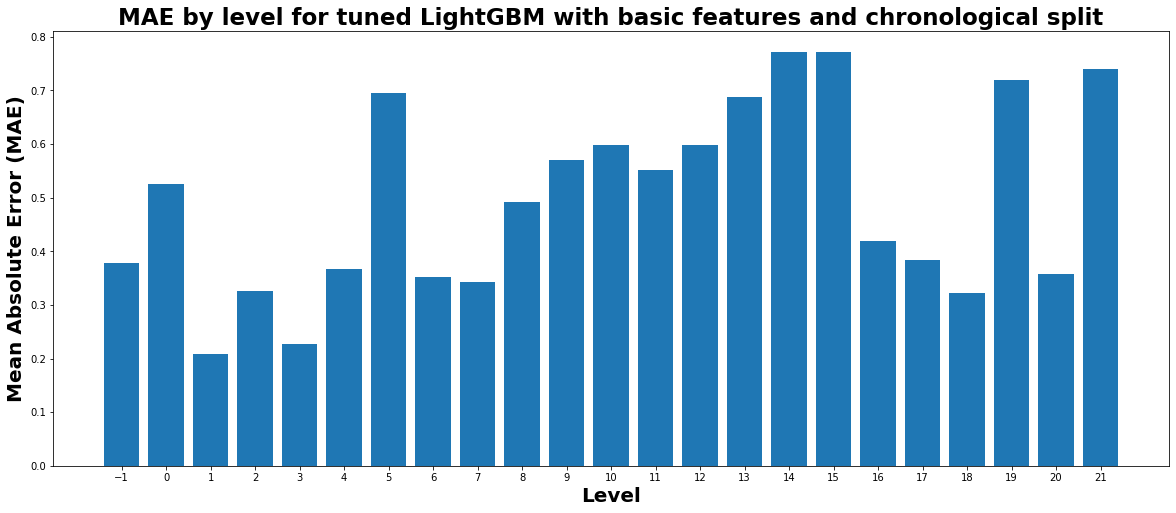

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.68

Round type: 0.5
RMSE: 0.71

Round type: 0.33
RMSE: 0.69

Round type: 0.45
RMSE: 0.71



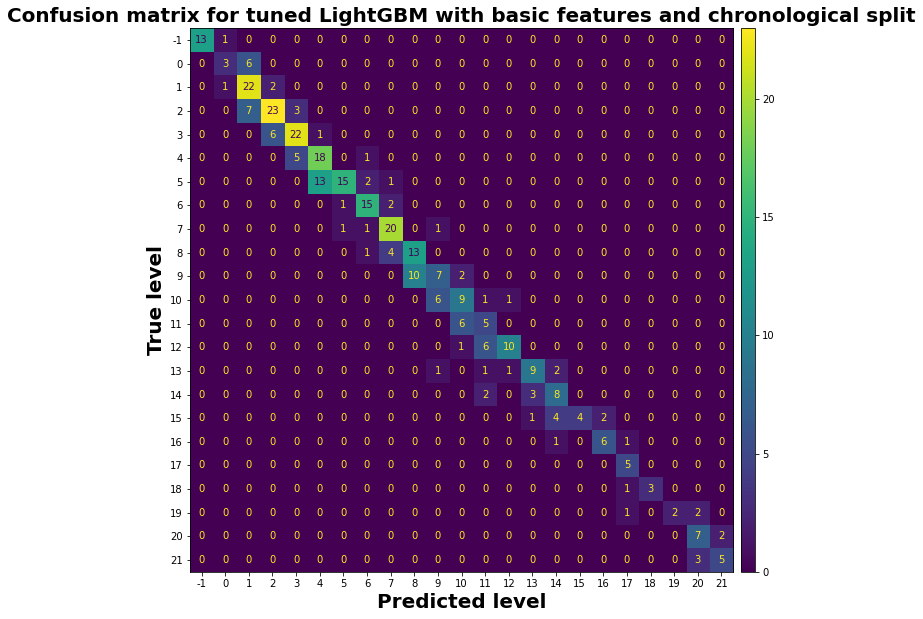

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 8
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.238538	valid_0's l1: 0.336785


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.49
MAE: 0.34


In [33]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

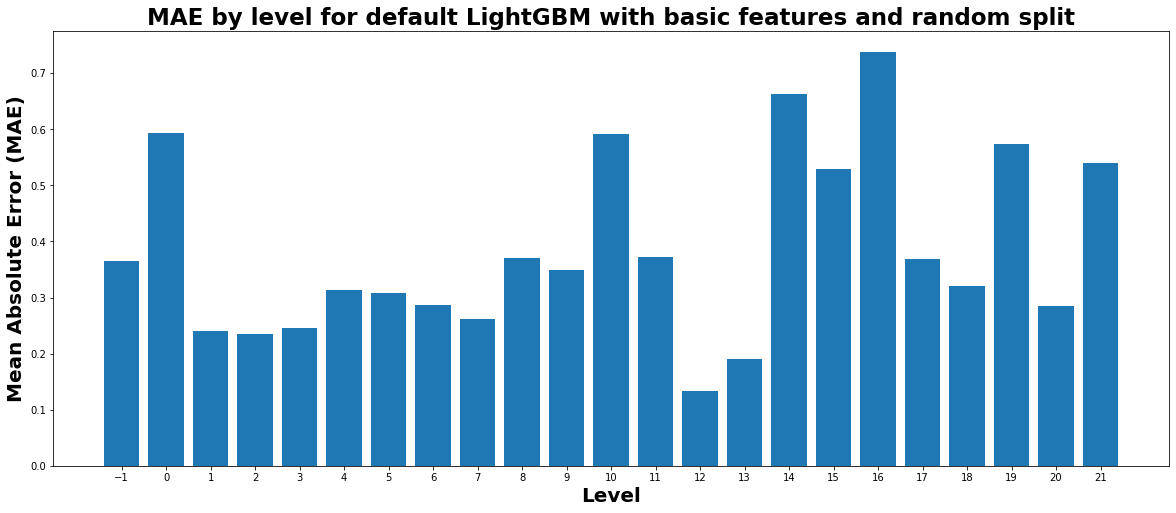

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [35]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.49

Round type: 0.5
RMSE: 0.51

Round type: 0.33
RMSE: 0.57

Round type: 0.45
RMSE: 0.51



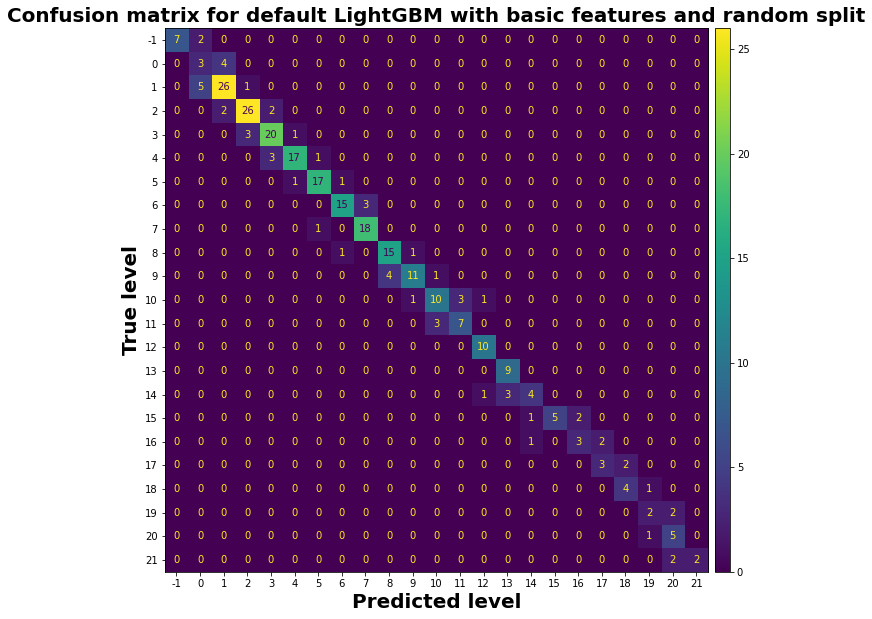

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 20:51:11,322] A new study created in memory with name: no-name-fef66fe4-52c3-48e9-a85e-cc7568e17979
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.258013 + 0.076644
[200]	cv_agg's l2: 0.260521 + 0.0774082


feature_fraction, val_score: 0.256439:  14%|######4                                      | 1/7 [00:02<00:15,  2.61s/it]

Early stopping, best iteration is:
[127]	cv_agg's l2: 0.256439 + 0.0774933
[100]	cv_agg's l2: 0.251819 + 0.085073
[200]	cv_agg's l2: 0.25242 + 0.0793632


feature_fraction, val_score: 0.250840:  29%|############8                                | 2/7 [00:05<00:13,  2.74s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.25084 + 0.0815097
[100]	cv_agg's l2: 0.247526 + 0.0606203
[200]	cv_agg's l2: 0.246099 + 0.0591382


feature_fraction, val_score: 0.245906:  43%|###################2                         | 3/7 [00:08<00:11,  2.88s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.35455 + 0.0436729
[200]	cv_agg's l2: 0.316251 + 0.0448899


feature_fraction, val_score: 0.245906:  57%|#########################7                   | 4/7 [00:11<00:08,  2.92s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.410116 + 0.0591789
[200]	cv_agg's l2: 0.361842 + 0.0532143


feature_fraction, val_score: 0.245906:  71%|################################1            | 5/7 [00:14<00:05,  2.95s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.250731 + 0.0749923
[200]	cv_agg's l2: 0.253092 + 0.0718588


feature_fraction, val_score: 0.245906:  86%|######################################5      | 6/7 [00:17<00:03,  3.10s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.251819 + 0.085073
[200]	cv_agg's l2: 0.25242 + 0.0793632


feature_fraction, val_score: 0.245906: 100%|#############################################| 7/7 [00:20<00:00,  3.00s/it]


Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899


num_leaves, val_score: 0.245906:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.247526 + 0.0606203
[200]	cv_agg's l2: 0.246099 + 0.0591382


num_leaves, val_score: 0.245906:   5%|##5                                               | 1/20 [00:03<00:59,  3.13s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.247526 + 0.0606203
[200]	cv_agg's l2: 0.246099 + 0.0591382


num_leaves, val_score: 0.245906:  10%|#####                                             | 2/20 [00:06<01:00,  3.39s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.247526 + 0.0606203
[200]	cv_agg's l2: 0.246099 + 0.0591382


num_leaves, val_score: 0.245906:  15%|#######5                                          | 3/20 [00:10<00:59,  3.48s/it]

Early stopping, best iteration is:
[176]	cv_agg's l2: 0.245906 + 0.0599899
[100]	cv_agg's l2: 0.245312 + 0.0589772


num_leaves, val_score: 0.245046:  20%|##########                                        | 4/20 [00:12<00:45,  2.84s/it]

[200]	cv_agg's l2: 0.247965 + 0.0599956
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905


num_leaves, val_score: 0.245046:  25%|############5                                     | 5/20 [00:12<00:29,  1.95s/it][I 2023-11-09 20:51:44,811] Trial 11 finished with value: 0.31553876572739215 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.24504561695362473.


[100]	cv_agg's l2: 0.317543 + 0.0900968
[200]	cv_agg's l2: 0.279807 + 0.0802482
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905


num_leaves, val_score: 0.245046:  30%|###############                                   | 6/20 [00:12<00:19,  1.41s/it]

[100]	cv_agg's l2: 0.317543 + 0.0900968
[200]	cv_agg's l2: 0.279807 + 0.0802482
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  35%|#################5                                | 7/20 [00:15<00:23,  1.77s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  40%|####################                              | 8/20 [00:17<00:23,  1.99s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  45%|######################5                           | 9/20 [00:20<00:24,  2.20s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  50%|########################5                        | 10/20 [00:22<00:22,  2.29s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  55%|##########################9                      | 11/20 [00:25<00:21,  2.38s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  60%|#############################4                   | 12/20 [00:28<00:19,  2.47s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  65%|###############################8                 | 13/20 [00:30<00:17,  2.46s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  70%|##################################3              | 14/20 [00:33<00:14,  2.45s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  75%|####################################7            | 15/20 [00:35<00:12,  2.49s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.247526 + 0.0606203


num_leaves, val_score: 0.245046:  80%|#######################################2         | 16/20 [00:38<00:09,  2.47s/it]

[200]	cv_agg's l2: 0.246099 + 0.0591382
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.245679 + 0.0613949


num_leaves, val_score: 0.245046:  85%|#########################################6       | 17/20 [00:40<00:07,  2.46s/it]

[200]	cv_agg's l2: 0.249074 + 0.0573115
Early stopping, best iteration is:
[102]	cv_agg's l2: 0.245046 + 0.058905
[100]	cv_agg's l2: 0.243703 + 0.0609857


num_leaves, val_score: 0.243227:  90%|############################################1    | 18/20 [00:42<00:04,  2.29s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.243227 + 0.0606252
[100]	cv_agg's l2: 0.245679 + 0.0613949


num_leaves, val_score: 0.243227:  95%|##############################################5  | 19/20 [00:44<00:02,  2.29s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.243227 + 0.0606252
[100]	cv_agg's l2: 0.243703 + 0.0609857


num_leaves, val_score: 0.243227: 100%|#################################################| 20/20 [00:46<00:00,  2.34s/it]


Early stopping, best iteration is:
[99]	cv_agg's l2: 0.243227 + 0.0606252


bagging, val_score: 0.243227:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.282939 + 0.0575262


bagging, val_score: 0.243227:  10%|#####3                                               | 1/10 [00:01<00:13,  1.51s/it]

Early stopping, best iteration is:
[99]	cv_agg's l2: 0.243227 + 0.0606252
[100]	cv_agg's l2: 0.239947 + 0.0521989


bagging, val_score: 0.238872:  10%|#####3                                               | 1/10 [00:03<00:13,  1.51s/it]

[200]	cv_agg's l2: 0.241032 + 0.0533253
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.238872 + 0.052011


bagging, val_score: 0.238872:  20%|##########6                                          | 2/10 [00:03<00:16,  2.01s/it]

[100]	cv_agg's l2: 0.243703 + 0.0609857


bagging, val_score: 0.238872:  20%|##########6                                          | 2/10 [00:05<00:16,  2.01s/it]

[200]	cv_agg's l2: 0.246932 + 0.059148
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.238872 + 0.052011


bagging, val_score: 0.238872:  30%|###############9                                     | 3/10 [00:05<00:14,  2.06s/it]

[100]	cv_agg's l2: 0.243703 + 0.0609857


bagging, val_score: 0.238872:  30%|###############9                                     | 3/10 [00:08<00:14,  2.06s/it]

[200]	cv_agg's l2: 0.246932 + 0.059148
Early stopping, best iteration is:
[120]	cv_agg's l2: 0.238872 + 0.052011


bagging, val_score: 0.238872:  40%|#####################2                               | 4/10 [00:08<00:12,  2.10s/it]

[100]	cv_agg's l2: 0.240111 + 0.0595225
[200]	cv_agg's l2: 0.241011 + 0.0584287


bagging, val_score: 0.238187:  50%|##########################5                          | 5/10 [00:10<00:11,  2.22s/it]

Early stopping, best iteration is:
[143]	cv_agg's l2: 0.238187 + 0.0582386
[100]	cv_agg's l2: 0.246137 + 0.0524969
[200]	cv_agg's l2: 0.246953 + 0.0500738


bagging, val_score: 0.238187:  60%|###############################8                     | 6/10 [00:13<00:09,  2.32s/it]

Early stopping, best iteration is:
[143]	cv_agg's l2: 0.238187 + 0.0582386
[100]	cv_agg's l2: 0.257004 + 0.0562531
[200]	cv_agg's l2: 0.25575 + 0.0514442


bagging, val_score: 0.238187:  70%|#####################################                | 7/10 [00:15<00:07,  2.35s/it]

Early stopping, best iteration is:
[143]	cv_agg's l2: 0.238187 + 0.0582386
[100]	cv_agg's l2: 0.237969 + 0.0477517


bagging, val_score: 0.236939:  80%|##########################################4          | 8/10 [00:17<00:04,  2.22s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.238869 + 0.0575213


bagging, val_score: 0.236939:  90%|###############################################7     | 9/10 [00:19<00:02,  2.13s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.243561 + 0.0611925


bagging, val_score: 0.236939: 100%|####################################################| 10/10 [00:21<00:00,  2.14s/it]


Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397


feature_fraction_stage2, val_score: 0.236939:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.237969 + 0.0477517


feature_fraction_stage2, val_score: 0.236939:  17%|######3                               | 1/6 [00:02<00:12,  2.46s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.237969 + 0.0477517


feature_fraction_stage2, val_score: 0.236939:  33%|############6                         | 2/6 [00:04<00:08,  2.20s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.237969 + 0.0477517


feature_fraction_stage2, val_score: 0.236939:  50%|###################                   | 3/6 [00:06<00:06,  2.07s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.401184 + 0.0559247


feature_fraction_stage2, val_score: 0.236939:  67%|#########################3            | 4/6 [00:08<00:04,  2.02s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.237969 + 0.0477517


feature_fraction_stage2, val_score: 0.236939:  83%|###############################6      | 5/6 [00:10<00:01,  1.96s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.401184 + 0.0559247


feature_fraction_stage2, val_score: 0.236939: 100%|######################################| 6/6 [00:12<00:00,  2.01s/it]


Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397


regularization_factors, val_score: 0.236939:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.237969 + 0.0477517


regularization_factors, val_score: 0.236939:   5%|#9                                    | 1/20 [00:01<00:36,  1.91s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.262447 + 0.0705452


regularization_factors, val_score: 0.236939:  10%|###8                                  | 2/20 [00:02<00:25,  1.42s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236939 + 0.0499397
[100]	cv_agg's l2: 0.237804 + 0.0482941


regularization_factors, val_score: 0.236644:  15%|#####7                                | 3/20 [00:04<00:27,  1.63s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482942


regularization_factors, val_score: 0.236644:  20%|#######6                              | 4/20 [00:06<00:28,  1.77s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237637 + 0.048002


regularization_factors, val_score: 0.236644:  25%|#########5                            | 5/20 [00:08<00:27,  1.84s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482943


regularization_factors, val_score: 0.236644:  30%|###########4                          | 6/20 [00:10<00:26,  1.89s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482942


regularization_factors, val_score: 0.236644:  35%|#############3                        | 7/20 [00:12<00:24,  1.92s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482941


regularization_factors, val_score: 0.236644:  40%|###############2                      | 8/20 [00:14<00:23,  1.95s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482941


regularization_factors, val_score: 0.236644:  45%|#################1                    | 9/20 [00:16<00:21,  1.94s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482942


regularization_factors, val_score: 0.236644:  50%|##################5                  | 10/20 [00:18<00:19,  1.93s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482941


regularization_factors, val_score: 0.236644:  55%|####################3                | 11/20 [00:20<00:17,  1.94s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500022
[100]	cv_agg's l2: 0.237804 + 0.0482941


regularization_factors, val_score: 0.236644:  60%|######################2              | 12/20 [00:22<00:15,  1.95s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500021
[100]	cv_agg's l2: 0.237804 + 0.0482941


regularization_factors, val_score: 0.236644:  65%|########################             | 13/20 [00:24<00:13,  1.97s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500021
[100]	cv_agg's l2: 0.237637 + 0.048002


regularization_factors, val_score: 0.236644:  70%|#########################9           | 14/20 [00:26<00:12,  2.02s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500021
[100]	cv_agg's l2: 0.237974 + 0.0477485


regularization_factors, val_score: 0.236644:  75%|###########################7         | 15/20 [00:28<00:10,  2.00s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500021
[100]	cv_agg's l2: 0.237974 + 0.0477485


regularization_factors, val_score: 0.236644:  80%|#############################6       | 16/20 [00:30<00:08,  2.01s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500021
[100]	cv_agg's l2: 0.237457 + 0.0473243


regularization_factors, val_score: 0.236644:  85%|###############################4     | 17/20 [00:32<00:05,  1.98s/it]

Early stopping, best iteration is:
[85]	cv_agg's l2: 0.236644 + 0.0500021
[100]	cv_agg's l2: 0.236024 + 0.0465056


regularization_factors, val_score: 0.235588:  90%|#################################3   | 18/20 [00:34<00:04,  2.03s/it]

Early stopping, best iteration is:
[97]	cv_agg's l2: 0.235588 + 0.0460616
[100]	cv_agg's l2: 0.237872 + 0.0494408


regularization_factors, val_score: 0.235588:  95%|###################################1 | 19/20 [00:37<00:02,  2.11s/it]

Early stopping, best iteration is:
[97]	cv_agg's l2: 0.235588 + 0.0460616
[100]	cv_agg's l2: 0.236842 + 0.0472727


regularization_factors, val_score: 0.235588: 100%|#####################################| 20/20 [00:39<00:00,  1.96s/it]


Early stopping, best iteration is:
[97]	cv_agg's l2: 0.235588 + 0.0460616


min_data_in_leaf, val_score: 0.235588:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.232791 + 0.050744


min_data_in_leaf, val_score: 0.231600:  20%|#########                                    | 1/5 [00:02<00:08,  2.03s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.2316 + 0.0519311
[100]	cv_agg's l2: 0.35602 + 0.0780318


min_data_in_leaf, val_score: 0.231600:  40%|##################                           | 2/5 [00:03<00:04,  1.41s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.2316 + 0.0519311
[100]	cv_agg's l2: 0.236276 + 0.0556763


min_data_in_leaf, val_score: 0.231600:  60%|###########################                  | 3/5 [00:04<00:03,  1.66s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.2316 + 0.0519311
[100]	cv_agg's l2: 0.987256 + 0.149848


min_data_in_leaf, val_score: 0.231600:  80%|####################################         | 4/5 [00:05<00:01,  1.27s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.2316 + 0.0519311
[100]	cv_agg's l2: 0.262796 + 0.0626527


min_data_in_leaf, val_score: 0.231600: 100%|#############################################| 5/5 [00:07<00:00,  1.47s/it]

Early stopping, best iteration is:
[83]	cv_agg's l2: 0.2316 + 0.0519311


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.2315997443374595
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0019742173611921455
    lambda_l2: 2.5915613451174507e-07
    num_leaves: 21
    feature_fraction: 0.6
    bagging_fraction: 0.8806236164114358
    bagging_freq: 3
    min_child_samples: 5


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.51
MAE test: 0.33



In [41]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

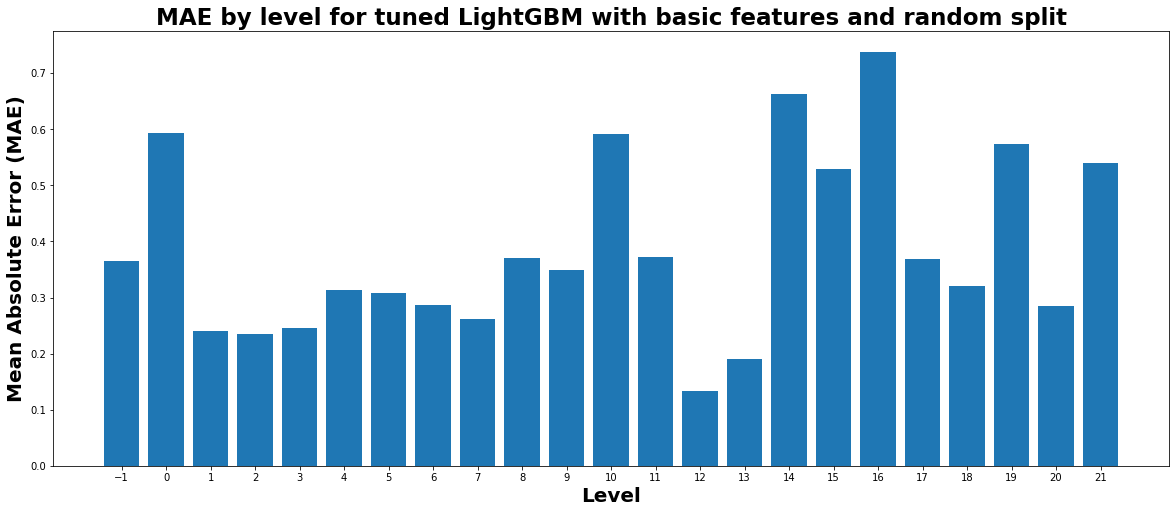

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.33

Round type: 0.5
RMSE: 0.34

Round type: 0.33
RMSE: 0.37

Round type: 0.45
RMSE: 0.36



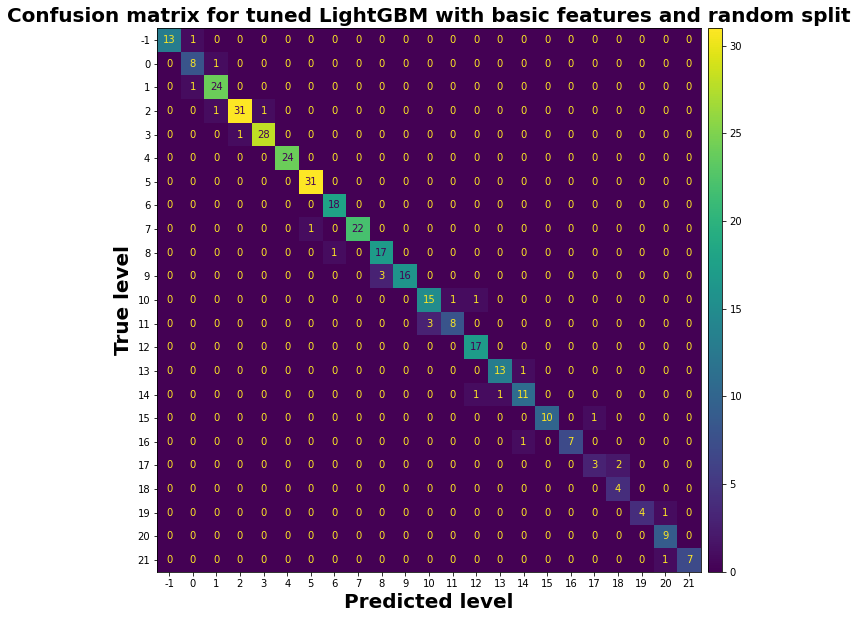

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.669004,0.467604
1,chronological,Optuna,basic,0.675257,0.479835
2,random,default,basic,0.488404,0.336785
3,random,Optuna,basic,0.506754,0.333149


In [46]:
from training.results import plot_summary

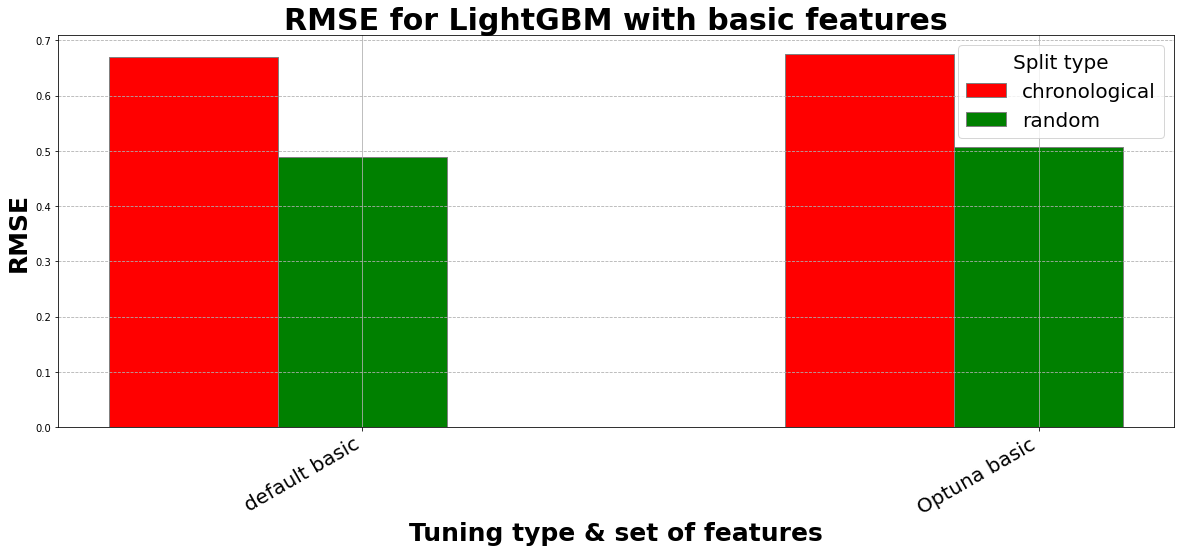

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

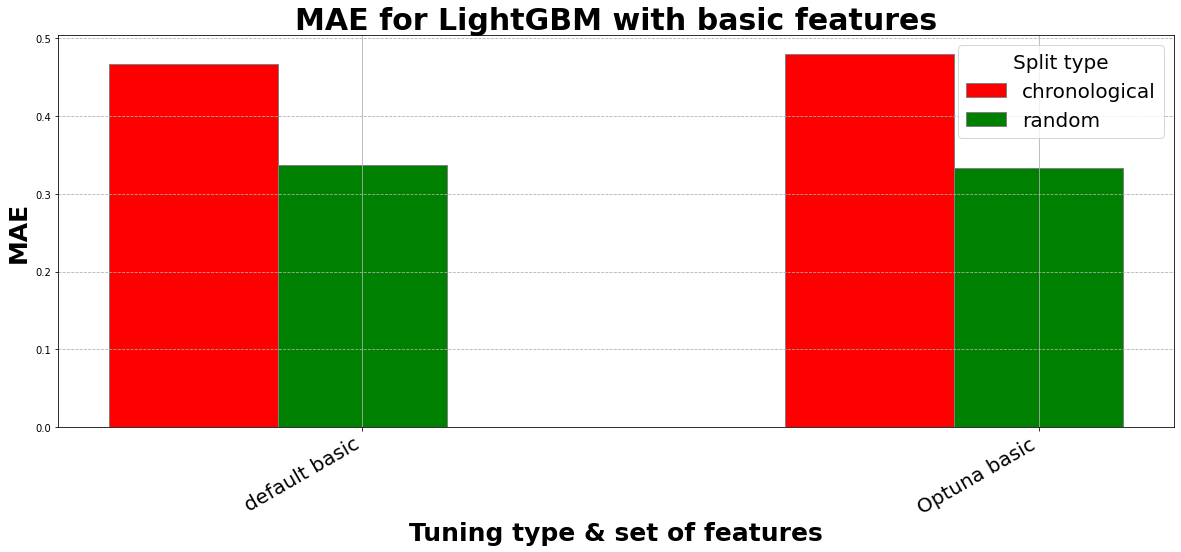

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [49]:
results.to_csv("./lightgbm_basic_results.csv")